In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, r'../..')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import imageio
import pickle
import os
from tqdm import tqdm_notebook as tqdm

from lib.video import *
from lib.utils import convert_time, start_table_to_dict, cur_frame, cur_time

In [3]:
from src.time_extractor import generate_static_mask, generate_green_mask

Use tqdm_notebook


In [44]:
UI_REAL = '../../data/train/real_start_train.csv'
UI_PREDICTION = '../../output/features/games_starts_train.csv'
VIDEO_DIR = '../../data/train/'
VIDEO = '645001_5.mp4'
VIDEO_PATH = VIDEO_DIR + 'resized_' + VIDEO
NONE_TYPE = 'NONE'
FULL_EVENT_TABLE = '../../data/test/' + 'events.csv'
GOOD_EVENTS = ['желтая карточка', 'гол', 'замена']

In [21]:
full_event_table = pd.read_csv(UI_REAL)\
    .drop(["first_start", "first_end", "second_start", "second_end"], axis=1)\
    .dropna()
#full_event_table = full_event_table[full_event_table['event_type'].isin(GOOD_EVENTS)]
full_event_table

,file_name,first_ui_start,first_ui_end,second_ui_start,second_ui_end
1,resized_641579_3.mp4,0:56,1:01,1:05:16,1:05:21
7,resized_639900_5.mp4,16:28,16:37,1:20:40,1:20:47
8,resized_639919_5.mp4,16:29,16:36,1:19:40,1:19:47
9,resized_639933_5.mp4,15:27,15:33,1:16:36,1:16:41
10,resized_639939_5.mp4,18:06,18:11,1:20:46,1:20:53
11,resized_640085_5.mp4,17:02,17:09,1:21:05,1:21:11
12,resized_640196_5.mp4,15:29,15:36,1:19:00,1:19:06


In [49]:
FILES = full_event_table['file_name'].unique()
','.join(FILES)

'resized_641579_3.mp4,resized_639900_5.mp4,resized_639919_5.mp4,resized_639933_5.mp4,resized_639939_5.mp4,resized_640085_5.mp4,resized_640196_5.mp4'

In [7]:
green_mask = generate_green_mask(VIDEO_PATH, proportion=0.02)
show_img(green_mask)

FileNotFoundError: No such file: '/home/wafemand/projs/Hackathon-media-2018/data/test/resized_645001_5.mp4'

In [56]:
HL, WL, H, W = 90, 105, 110, 130
def filter_mask(ui_mask, k=0):
    ui_mask = ui_mask.copy()
    mask = np.ones_like(ui_mask)
    mask[HL:H, WL:W] = 0
    ui_mask[mask] = 0
    n, m = ui_mask.shape
    mask = np.zeros_like(ui_mask)
    for x in np.arange(k, n-k):
        for y in np.arange(k, m-k):
            for dx in np.arange(-k, k+1):
                for dy in np.arange(-k, k+1):
                    if ui_mask[x+dx][y+dy]:
                        mask[x][y] = 1
    ui_mask[mask] = 1
    return ui_mask

In [58]:
def get_i_frame(filename, i_frame):
    for i, frame in enumerate(imageio.get_reader(filename)):
        if i == i_frame:
            return frame

#frame = get_i_frame(VIDEO_DIR + "resized_645001_5.mp4", 374)
#show_img(frame)
frame.shape
convert_time("10:10")

610

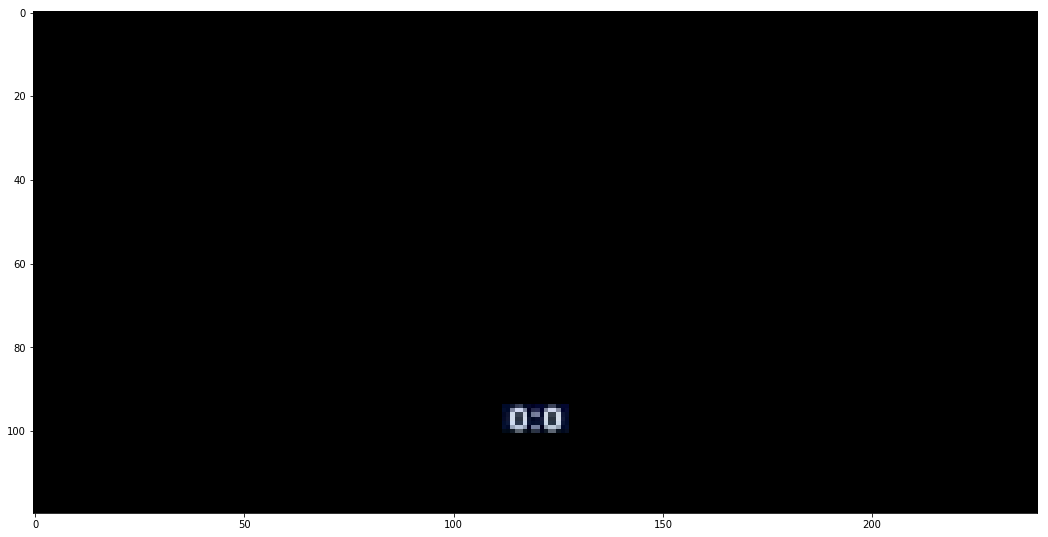

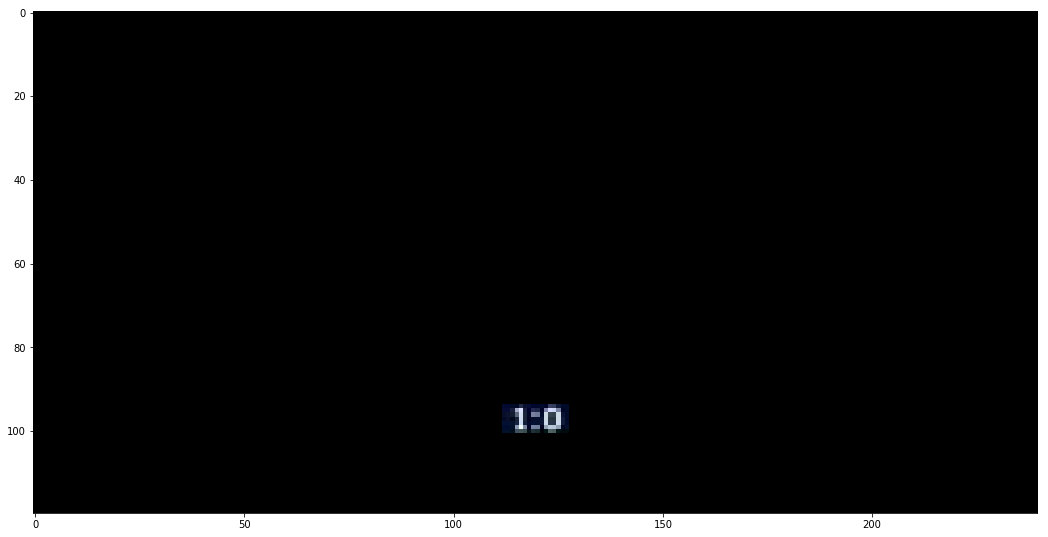

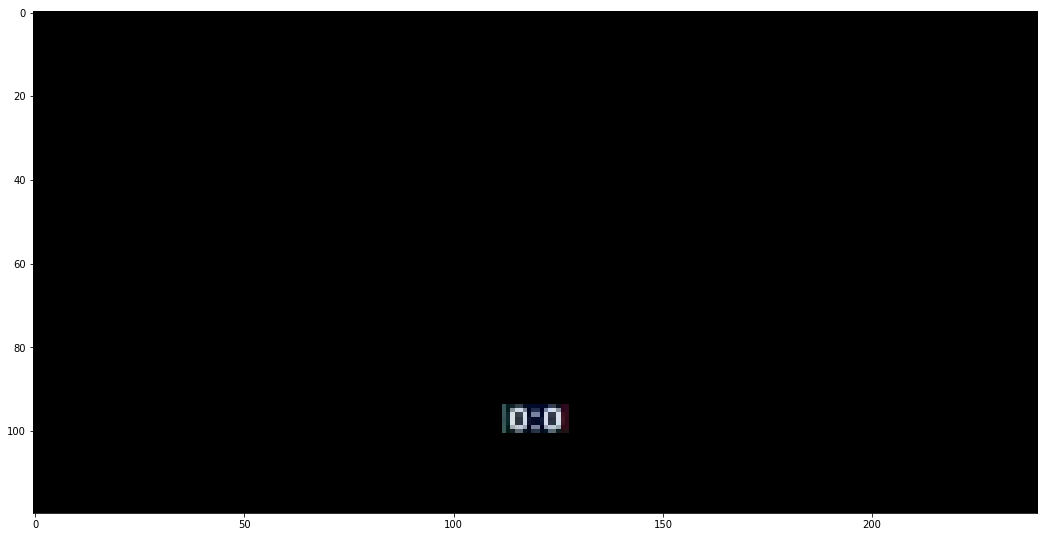

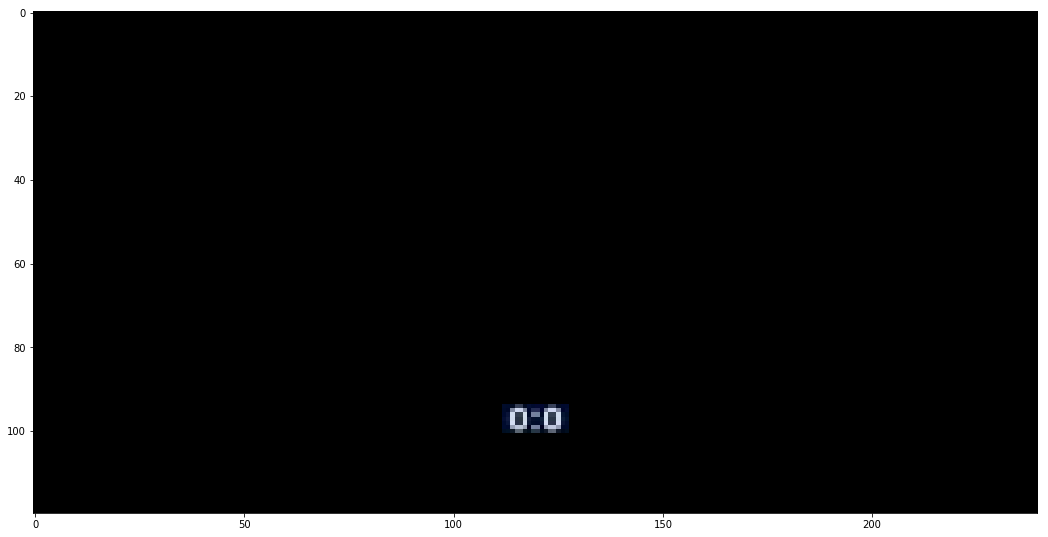

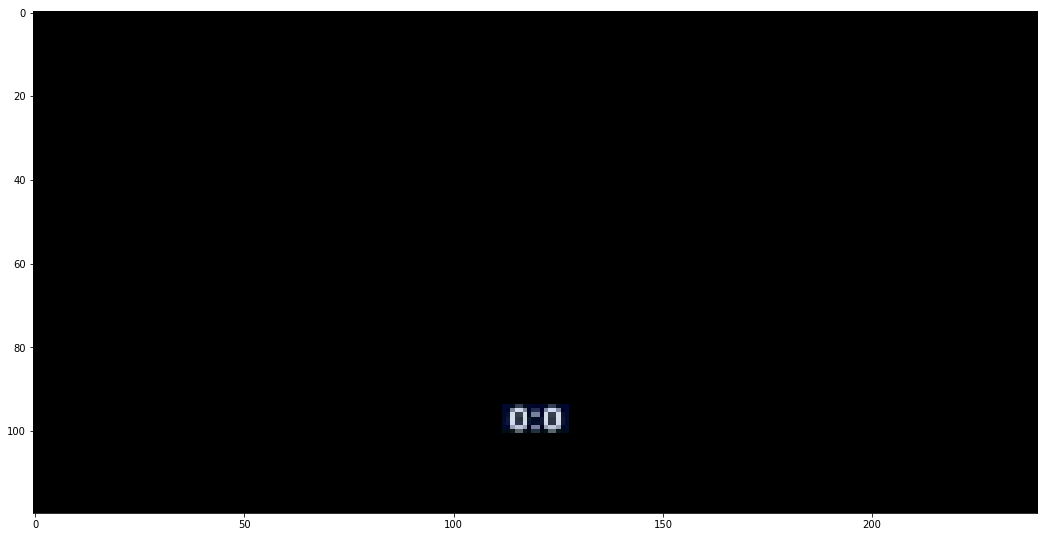

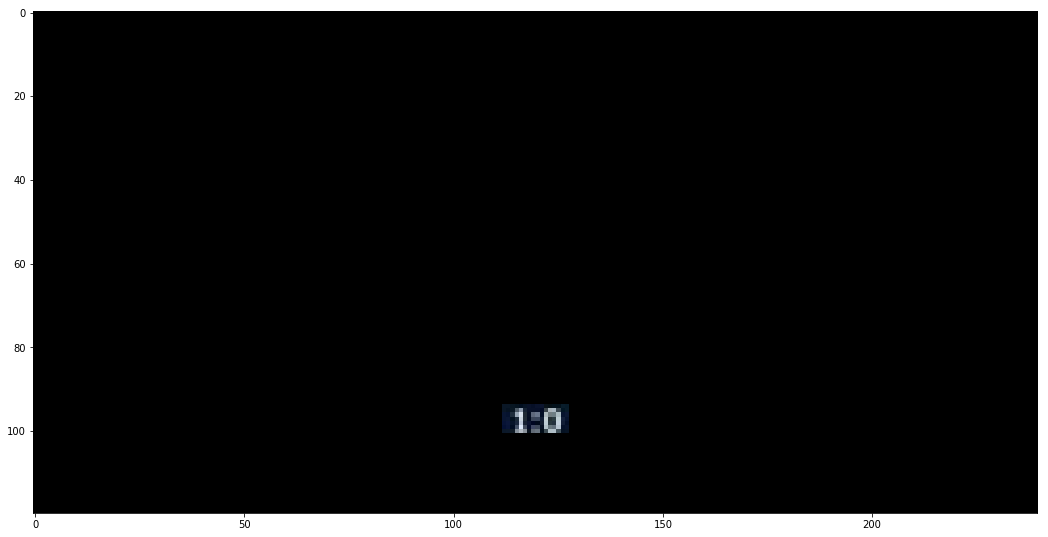

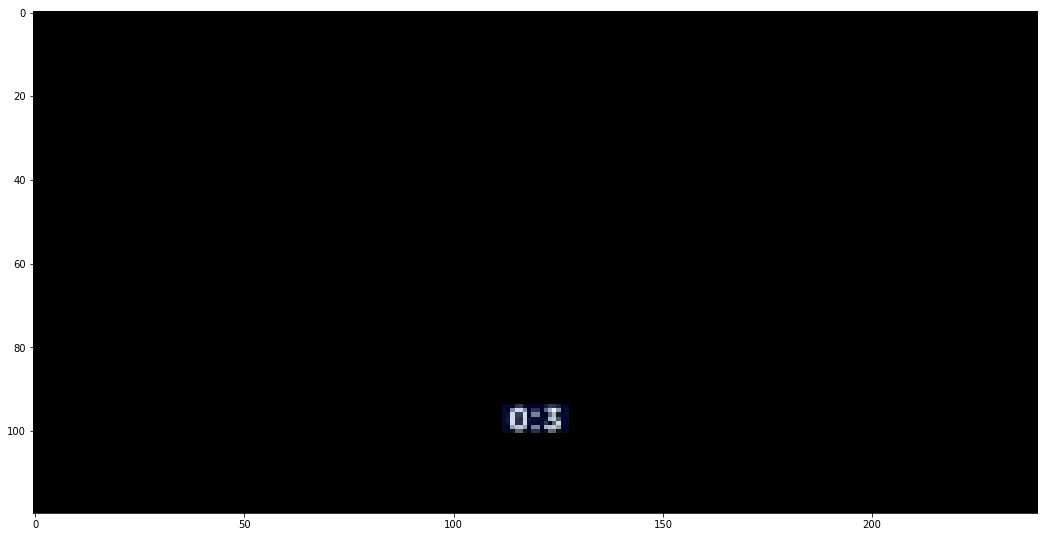

In [68]:
def gen_const_mask():
    mask = np.zeros((120, 240), 'bool')
    mask[94:101, 112:128] = True
    #mask[5:30, 20:50] = True
    #mask[10:20, 20:35] = True
    return mask


def gen_const_mask3():
    mask = np.zeros((120, 240, 3), 'bool')
    mask[94:101, 112:128] = np.ones(3, 'bool')
    #mask[5:30, 20:50] = True
    #mask[10:20, 20:35] = True
    return mask


UI_MASK = gen_const_mask()

for _, row in full_event_table.iterrows():
    frame = get_i_frame(VIDEO_DIR + row.file_name, convert_time(row.second_ui_start) + 3)
    show_img(frame*gen_const_mask3())
#UI_MASK.shape

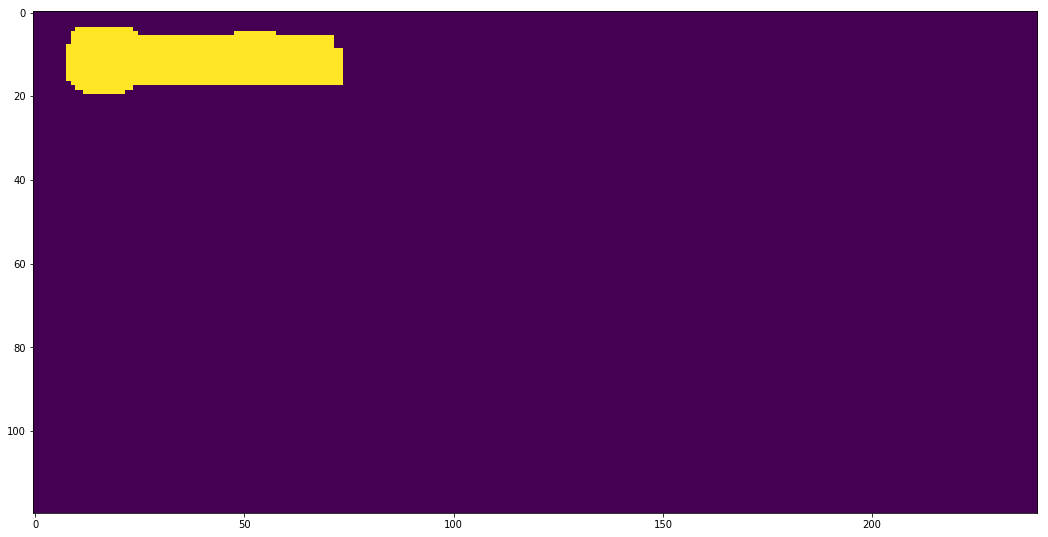

In [118]:
UI_MASK = filter_mask(green_mask, 4)
show_img(UI_MASK)

In [69]:
def preproc_same(frame):
    frame = np.array(frame, dtype='float')
    return frame

In [70]:
def preproc_mask(frame):
    frame = np.array(frame, dtype='float')
    frame[~UI_MASK] = 0
    frame = frame[HL:H, WL:W]
    return frame

In [71]:
PREPROC_FUN = preproc_mask
IS_FLATTEN = True
NONK = 20
NN = 1000

In [72]:
def show_event_imgs(file_name):
    path = VIDEO_DIR + file_name
    n_frame = get_total_len(path)
    events_type = [None] * n_frame
    for _, row in full_event_table.iterrows():
        if row.file_name != file_name:
            continue
            
        def proc(l, r, event_type):
            print(event_type, (l, r), r-l+1)
            for i in range(l, r+1):
                events_type[i] = event_type
        
        l, r = convert_time(row.first_ui_start)+3, convert_time(row.first_ui_end)-2
        l2, r2 = convert_time(row.second_ui_start)+3, convert_time(row.second_ui_end)-2
        proc(l, r, "first")
        proc(l2, r2, "second")
        
    for frame, event_type in tqdm(zip(get_reader(path), events_type)):
        frame = PREPROC_FUN(frame)
        if event_type is not None:
            show_img(frame.astype('uint8'), k=0.5)
            plt.show()

first (59, 59) 1
second (3919, 3919) 1


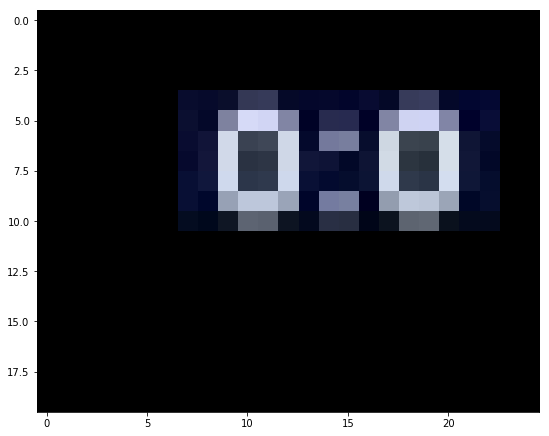

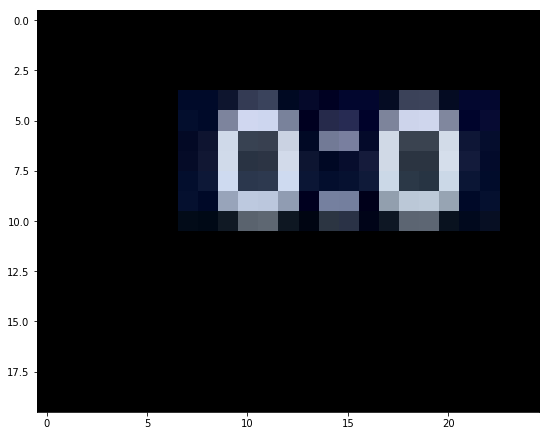

In [73]:
show_event_imgs(FILES[0])

first (991, 995) 5
second (4843, 4845) 3


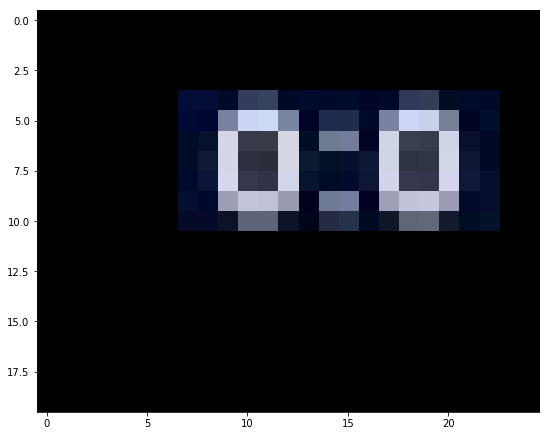

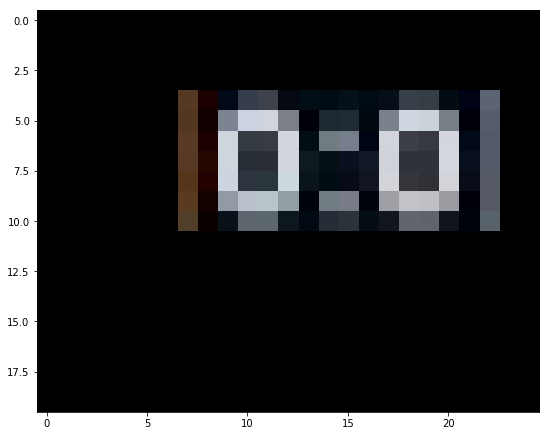

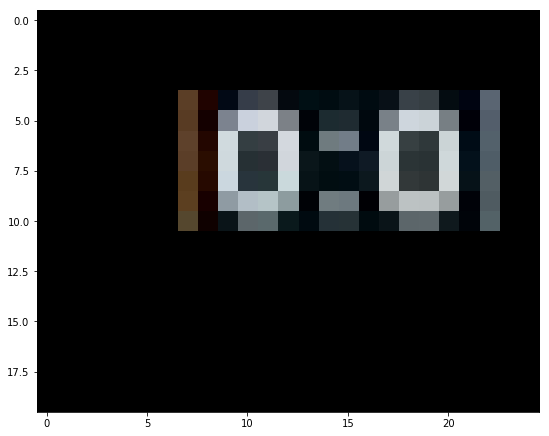

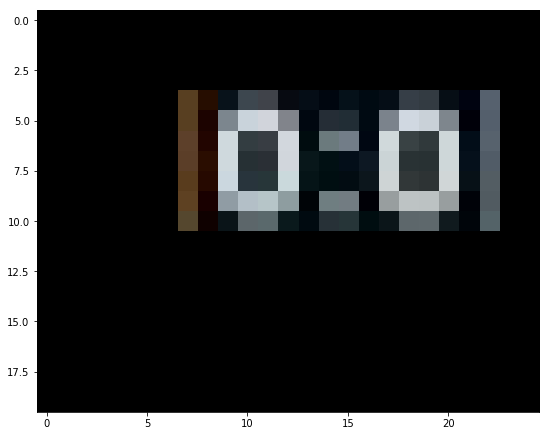

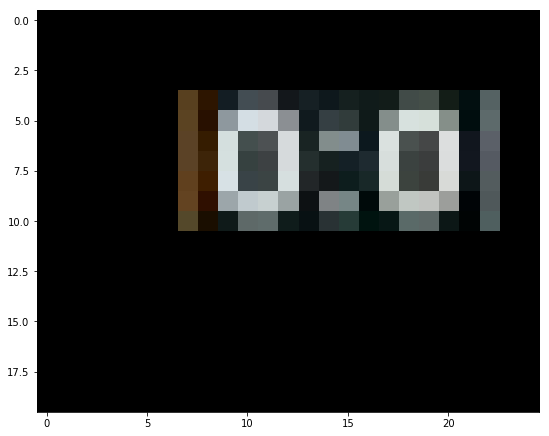

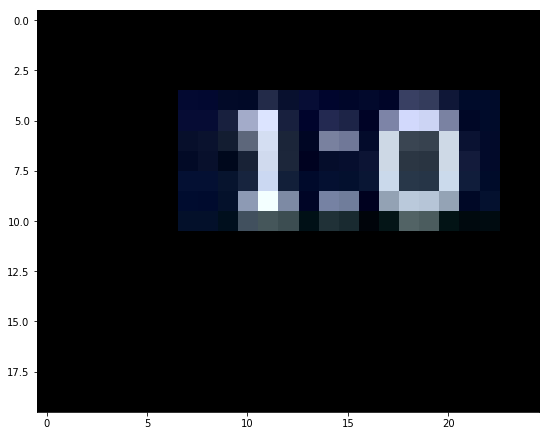

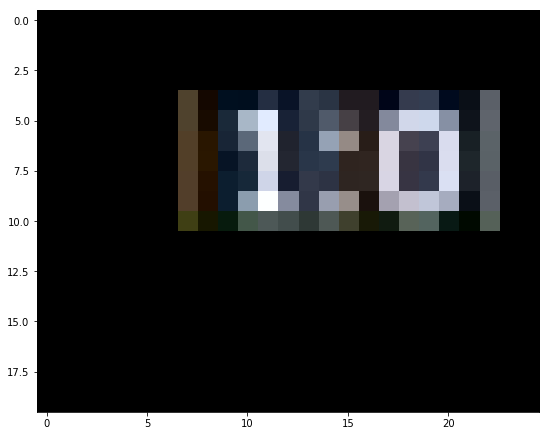

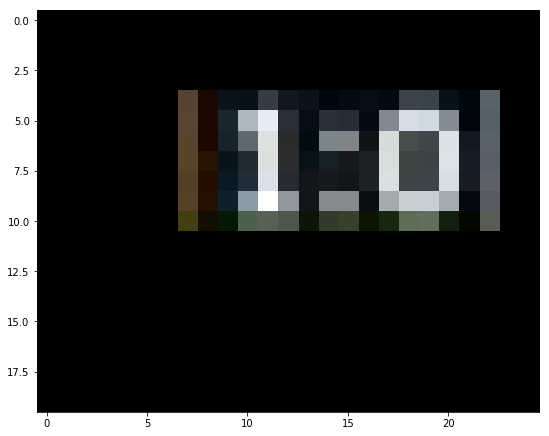

In [74]:
show_event_imgs(FILES[1])

In [81]:
def create_Xy(file_name):
    path = VIDEO_DIR + file_name
    n_frame = get_total_len(path)
    events_type = [None] * n_frame
    for _, row in full_event_table.iterrows():
        if row.file_name != file_name:
            continue
        
        def proc(l, r, event_type):
            print(event_type, (l, r), r-l+1)
            for i in range(l, r+1):
                events_type[i] = event_type
        
        l, r = convert_time(row.first_ui_start)+3, convert_time(row.first_ui_end)-1
        l2, r2 = convert_time(row.second_ui_start)+3, convert_time(row.second_ui_end)-1
        proc(l, r, "score")
        proc(l2, r2, "score")
        
        """if row.file_name != file_name:
            continue
        l, r = convert_time(row.event_time)+2, convert_time(row.event_end)-1
        for i in range(l, r+1):
            events_type[i] = row.event_type"""
    X, y = [], []
    bad_pairs = []
    shape_frame = ()
    for frame, event_type in tqdm(zip(get_reader(path), events_type)):
        frame = PREPROC_FUN(frame)
        shape_frame = frame.shape
        if IS_FLATTEN:
            frame = frame.reshape((-1))
        if event_type is None:
            bad_pairs.append((frame, NONE_TYPE))
        else:
            y.append(event_type)
            X.append(frame)
    print(shape_frame)
    #n_pairs = min(int(len(y) * NONK), len(bad_pairs))
    n_pairs = NN
    for i in np.random.choice(range(len(bad_pairs)), n_pairs, replace=False):
        X.append(bad_pairs[i][0])
        y.append(bad_pairs[i][1])
    return X, y

In [82]:
def create_dataset(files):
    X, y, file_name = [], [], []
    for file in tqdm(files):
        X_file, y_file = create_Xy(file)
        print('create_dataset: len(y_file)={}'.format(len(y_file)))
        X += X_file
        y += y_file
        file_name += [file] * len(y_file)
    return np.array(X), np.array(y), np.array(file_name)

In [83]:
X, y, file_name = create_dataset(FILES)

score (59, 60) 2
score (3919, 3920) 2


(20, 25, 3)
create_dataset: len(y_file)=1004
score (991, 996) 6
score (4843, 4846) 4


(20, 25, 3)
create_dataset: len(y_file)=1010
score (992, 995) 4
score (4783, 4786) 4


(20, 25, 3)
create_dataset: len(y_file)=1008
score (930, 932) 3
score (4599, 4600) 2


(20, 25, 3)
create_dataset: len(y_file)=1005
score (1089, 1090) 2
score (4849, 4852) 4


(20, 25, 3)
create_dataset: len(y_file)=1006
score (1025, 1028) 4
score (4868, 4870) 3


(20, 25, 3)
create_dataset: len(y_file)=1007
score (932, 935) 4
score (4743, 4745) 3


(20, 25, 3)
create_dataset: len(y_file)=1007



In [84]:
print(np.unique(file_name))
print(X.shape)

['resized_639900_5.mp4' 'resized_639919_5.mp4' 'resized_639933_5.mp4'
 'resized_639939_5.mp4' 'resized_640085_5.mp4' 'resized_640196_5.mp4'
 'resized_641579_3.mp4']
(7047, 1500)


In [88]:
from sklearn.metrics import f1_score, accuracy_score

def run_cross_val(model, X, y, file_name, count=None):
    X = np.array(X)
    y = np.array(y)
    file_name = np.array(file_name)
    ind = 0
    f1s, acs, nonnan_f1s = [], [], []
    for file in tqdm(np.unique(file_name)):
        if ind == count:
            break
        train_ind = file_name != file
        X_train, y_train, X_test, y_test = X[train_ind], y[train_ind], X[~train_ind], y[~train_ind]
        print('run_cross_val: #{} train_size={} test_size={}'.format(
            ind, len(y_train), len(y_test)), end=' ')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        f1, ac = f1_score(y_test, y_pred, average='macro'), accuracy_score(y_test, y_pred)
        
        nonan_ind = (y_test != NONE_TYPE) | (y_pred != NONE_TYPE)
        
        nonnan_f1 = f1_score(y_test[nonan_ind], y_pred[nonan_ind], average='macro')
        
        f1s.append(f1)
        acs.append(ac)
        nonnan_f1s.append(nonnan_f1)
        print('f1={} ac={} nonnan_f1={}'.format(f1, ac, nonnan_f1))
        
        ind += 1
    return np.mean(f1s), np.mean(acs), np.mean(nonnan_f1s)

In [89]:
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.pipeline import make_pipeline, make_union
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import PolynomialFeatures

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [90]:
def test_models(models, names=None):
    if names is None:
        names = [model.__class__.__name__ for model in models]
    assert(len(models) == len(names))
    scores = []
    for model, name in zip(models, names):
        print(name)
        score = run_cross_val(model, X, y, file_name)
        scores.append((name, score))
        print('Total: f1={:0.5} ac={:0.5} nonan_f1={:0.5}'.format(*score))
        print('#'*30 + '\n'*3)
    return scores

In [ ]:
class ManualClassifier:
    def __init__(self):
        pass
    
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        

In [92]:
%%time
one_ridge = RidgeClassifier(normalize=True, class_weight='balanced')
test_models([one_ridge])

RidgeClassifier


run_cross_val: #0 train_size=6037 test_size=1010 f1=0.9156646626586507 ac=0.996039603960396 nonnan_f1=0.41666666666666663
run_cross_val: #1 train_size=6039 test_size=1008 f1=0.8796992481203008 ac=0.9950396825396826 nonnan_f1=0.380952380952381
run_cross_val: #2 train_size=6042 test_size=1005 f1=0.7048086606243706 ac=0.9860696517412936 nonnan_f1=0.20833333333333334
run_cross_val: #3 train_size=6041 test_size=1006 f1=0.7026101170292312 ac=0.9831013916500994 nonnan_f1=0.20689655172413793
run_cross_val: #4 train_size=6040 test_size=1007 f1=0.8878868848808729 ac=0.9960278053624627 nonnan_f1=0.3888888888888889
run_cross_val: #5 train_size=6040 test_size=1007 f1=0.7891541038525963 ac=0.9900695134061569 nonnan_f1=0.2916666666666667
run_cross_val: #6 train_size=6043 test_size=1004 f1=0.6433525903490568 ac=0.9810756972111554 nonnan_f1=0.14814814814814817

Total: f1=0.78903 ac=0.98963 nonan_f1=0.29165
##############################



CPU times: user 8.38 s, sys: 3.78 s, total: 12.2 s
Wall time: 4

In [93]:
for type_i in range(4):
    coef_img = one_ridge.coef_[type_i].reshape((25, 50, 3))
    show_img(coef_img[:,:,2])

ValueError: cannot reshape array of size 1500 into shape (25,50,3)

In [96]:
%%time
# TOO LONG

models = [
    RidgeClassifier(normalize=True, class_weight='balanced'),
    RidgeClassifier(),
    RidgeClassifier(normalize=True),
    LogisticRegression(),
    make_pipeline(GaussianRandomProjection(n_components=100), KNeighborsClassifier()),
    RandomForestClassifier(),
]
test_models(models)

RidgeClassifier


run_cross_val: #0 train_size=6037 test_size=1010 f1=0.9156646626586507 ac=0.996039603960396 nonnan_f1=0.41666666666666663
run_cross_val: #1 train_size=6039 test_size=1008 f1=0.8796992481203008 ac=0.9950396825396826 nonnan_f1=0.380952380952381
run_cross_val: #2 train_size=6042 test_size=1005 f1=0.7048086606243706 ac=0.9860696517412936 nonnan_f1=0.20833333333333334
run_cross_val: #3 train_size=6041 test_size=1006 f1=0.7026101170292312 ac=0.9831013916500994 nonnan_f1=0.20689655172413793
run_cross_val: #4 train_size=6040 test_size=1007 f1=0.8878868848808729 ac=0.9960278053624627 nonnan_f1=0.3888888888888889
run_cross_val: #5 train_size=6040 test_size=1007 f1=0.7891541038525963 ac=0.9900695134061569 nonnan_f1=0.2916666666666667
run_cross_val: #6 train_size=6043 test_size=1004 f1=0.6433525903490568 ac=0.9810756972111554 nonnan_f1=0.14814814814814817

Total: f1=0.78903 ac=0.98963 nonan_f1=0.29165
##############################



RidgeClassifier


run_cross_val: #0 train_size=6037 test_size=1010 f1=0.8621348621348621 ac=0.994059405940594 nonnan_f1=0.3636363636363636
run_cross_val: #1 train_size=6039 test_size=1008 f1=0.5980059820538385 ac=0.9920634920634921 nonnan_f1=0.1
run_cross_val: #2 train_size=6042 test_size=1005 f1=0.7849654090293132 ac=0.9970149253731343 nonnan_f1=0.28571428571428575
run_cross_val: #3 train_size=6041 test_size=1006 f1=0.7026101170292312 ac=0.9831013916500994 nonnan_f1=0.20689655172413793
run_cross_val: #4 train_size=6040 test_size=1007 f1=0.7714791449189851 ac=0.9950347567030785 nonnan_f1=0.2727272727272727
run_cross_val: #5 train_size=6040 test_size=1007 f1=0.8628874869513911 ac=0.997020854021847 nonnan_f1=0.36363636363636365
run_cross_val: #6 train_size=6043 test_size=1004 f1=0.749 ac=0.9960159362549801 nonnan_f1=0.25

Total: f1=0.76158 ac=0.99347 nonan_f1=0.26323
##############################



RidgeClassifier


run_cross_val: #0 train_size=6037 test_size=1010 f1=0.4975124378109453 ac=0.9900990099009901 nonnan_f1=0.0
run_cross_val: #1 train_size=6039 test_size=1008 f1=0.49800796812749004 ac=0.9920634920634921 nonnan_f1=0.0
run_cross_val: #2 train_size=6042 test_size=1005 f1=0.49875311720698257 ac=0.9950248756218906 nonnan_f1=0.0
run_cross_val: #3 train_size=6041 test_size=1006 f1=0.4985044865403789 ac=0.9940357852882704 nonnan_f1=0.0
run_cross_val: #4 train_size=6040 test_size=1007 f1=0.4982561036372696 ac=0.9930486593843099 nonnan_f1=0.0
run_cross_val: #5 train_size=6040 test_size=1007 f1=0.4982561036372696 ac=0.9930486593843099 nonnan_f1=0.0
run_cross_val: #6 train_size=6043 test_size=1004 f1=0.499001996007984 ac=0.9960159362549801 nonnan_f1=0.0

Total: f1=0.49833 ac=0.99333 nonan_f1=0.0
##############################



LogisticRegression


run_cross_val: #0 train_size=6037 test_size=1010 f1=0.7842187722546646 ac=0.994059405940594 nonnan_f1=0.28571428571428575
run_cross_val: #1 train_size=6039 test_size=1008 f1=0.6093672147483806 ac=0.9930555555555556 nonnan_f1=0.1111111111111111
run_cross_val: #2 train_size=6042 test_size=1005 f1=0.680067306380463 ac=0.9930348258706467 nonnan_f1=0.1818181818181818
run_cross_val: #3 train_size=6041 test_size=1006 f1=0.682449494949495 ac=0.9801192842942346 nonnan_f1=0.1875
run_cross_val: #4 train_size=6040 test_size=1007 f1=0.4982561036372696 ac=0.9930486593843099 nonnan_f1=0.0
run_cross_val: #5 train_size=6040 test_size=1007 f1=0.8323343323343323 ac=0.9960278053624627 nonnan_f1=0.3333333333333333
run_cross_val: #6 train_size=6043 test_size=1004 f1=0.6984984984984985 ac=0.9940239043824701 nonnan_f1=0.2

Total: f1=0.6836 ac=0.99191 nonan_f1=0.18564
##############################



Pipeline


run_cross_val: #0 train_size=6037 test_size=1010 f1=0.8140403482469292 ac=0.9930693069306931 nonnan_f1=0.3157894736842105
run_cross_val: #1 train_size=6039 test_size=1008 f1=0.898997995991984 ac=0.996031746031746 nonnan_f1=0.4
run_cross_val: #2 train_size=6042 test_size=1005 f1=0.7849654090293132 ac=0.9970149253731343 nonnan_f1=0.28571428571428575
run_cross_val: #3 train_size=6041 test_size=1006 f1=0.7026101170292312 ac=0.9831013916500994 nonnan_f1=0.20689655172413793
run_cross_val: #4 train_size=6040 test_size=1007 f1=0.4982561036372696 ac=0.9930486593843099 nonnan_f1=0.0
run_cross_val: #5 train_size=6040 test_size=1007 f1=0.816173786053304 ac=0.9920556107249255 nonnan_f1=0.3181818181818182
run_cross_val: #6 train_size=6043 test_size=1004 f1=0.749 ac=0.9960159362549801 nonnan_f1=0.25

Total: f1=0.75201 ac=0.99291 nonan_f1=0.2538
##############################



RandomForestClassifier


run_cross_val: #0 train_size=6037 test_size=1010 f1=0.4975124378109453 ac=0.9900990099009901 nonnan_f1=0.0
run_cross_val: #1 train_size=6039 test_size=1008 f1=0.49800796812749004 ac=0.9920634920634921 nonnan_f1=0.0
run_cross_val: #2 train_size=6042 test_size=1005 f1=0.7849654090293132 ac=0.9970149253731343 nonnan_f1=0.28571428571428575
run_cross_val: #3 train_size=6041 test_size=1006 f1=0.6882794949260206 ac=0.9840954274353877 nonnan_f1=0.1923076923076923
run_cross_val: #4 train_size=6040 test_size=1007 f1=0.4982561036372696 ac=0.9930486593843099 nonnan_f1=0.0
run_cross_val: #5 train_size=6040 test_size=1007 f1=0.7990019960079839 ac=0.9960278053624627 nonnan_f1=0.3
run_cross_val: #6 train_size=6043 test_size=1004 f1=0.499001996007984 ac=0.9960159362549801 nonnan_f1=0.0

Total: f1=0.60929 ac=0.99262 nonan_f1=0.11115
##############################



CPU times: user 46.8 s, sys: 15.6 s, total: 1min 2s
Wall time: 32.9 s
